# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
 

### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_excel('geo_comment.xlsx').drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 2.7+ MB


In [5]:
data.comment_class.value_counts()

-1    58552
 1    11830
Name: comment_class, dtype: int64

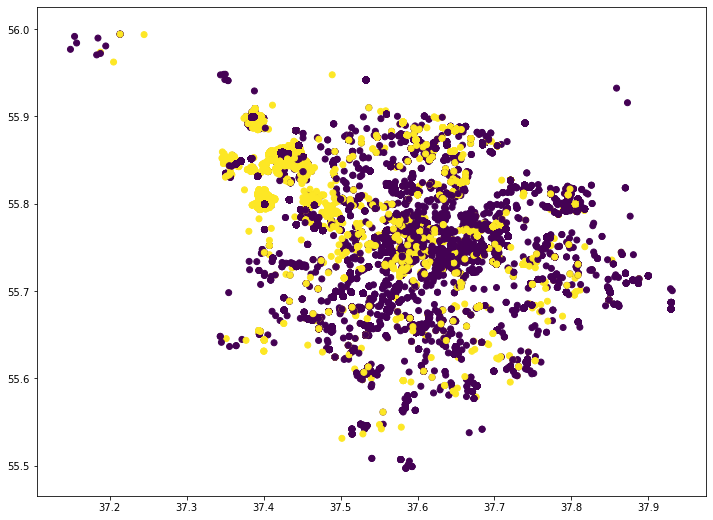

In [6]:
plt.figure(figsize=(12, 9))
plt.scatter(data.x, data.y, c=data.comment_class, )
plt.show()

In [7]:
def fmt_title(title, alg_name, y_pred, X):
    return "{}({})\nSilhouette {:.2f}".format(
        title,
        alg_name,
        silhouette_score(X, y_pred)
    )

def prepare_pipeline_and_predict(algorithm, X):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('alg', algorithm)])
    clusters = pipeline.fit_predict(X)
    return (pipeline, clusters)

def plot_clusters(items):
    cnt = len(items) if isinstance(items, list) else 1
    _, axes = plt.subplots(1, cnt, figsize=(12*cnt, 9))
    for ax, item in zip(axes if cnt > 1 else [axes], items if cnt > 1 else [items]):
        title, pipeline, X, y_pred = item
        algorithm = pipeline["alg"]

        ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='autumn', s=60, alpha=0.2)
        ax.set_title(fmt_title(title, algorithm.__class__.__name__, y_pred, X))

        if hasattr(algorithm, "cluster_centers_"):
            claster_centers_scaled = algorithm.cluster_centers_
            centers = pipeline[:1].inverse_transform(claster_centers_scaled)
            ax.scatter(centers[:, 0], centers[:, 1], s=50)
    plt.show()

Выбираем для начала KMeans с 5 кластерами

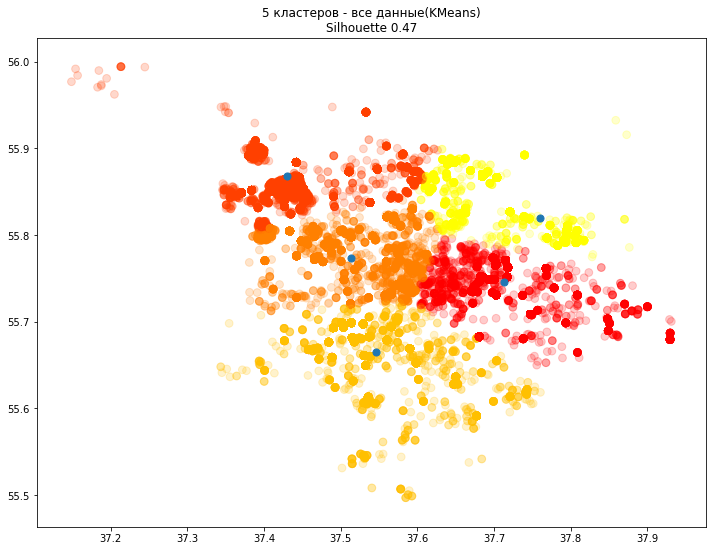

Wall time: 1min 45s


In [8]:
%%time

X = np.c_[data.x, data.y]
pipeline, y_pred = prepare_pipeline_and_predict(KMeans(n_clusters=5), X)
plot_clusters(("5 кластеров - все данные", pipeline, X, y_pred))

Разделим данные на два подмножества по результату голосования и отдельно кластерезуем. Также используем 5 кластеров

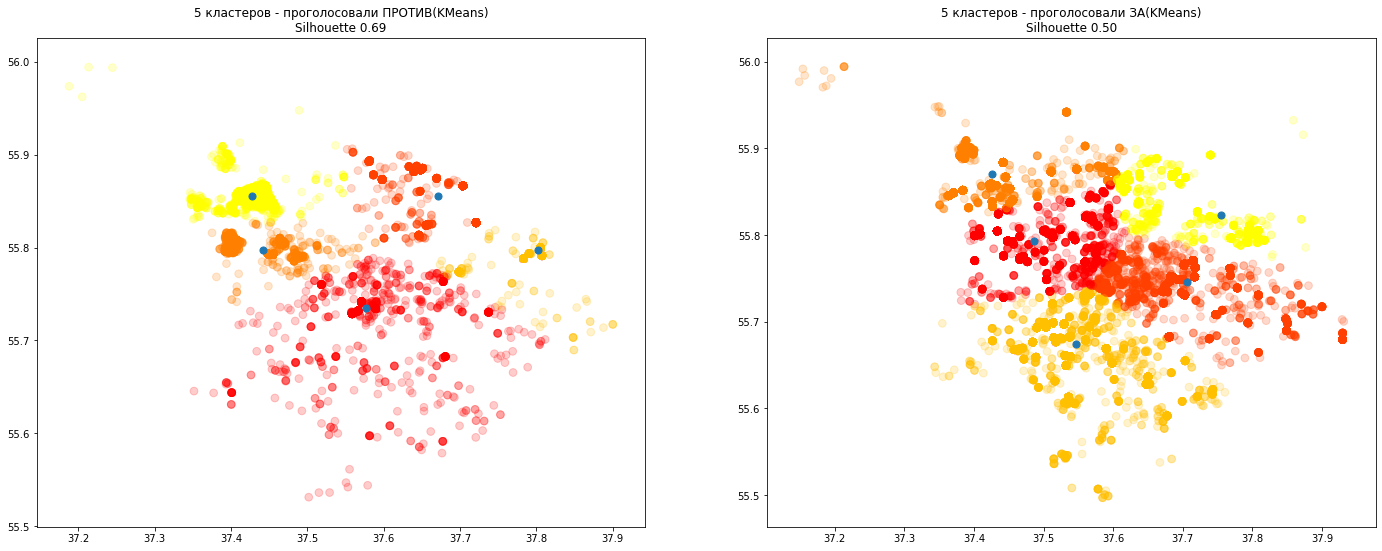

Wall time: 1min 19s


In [9]:
%%time

X_vf = data[data.comment_class == 1][['x', 'y']].to_numpy()
X_va = data[data.comment_class == -1][['x', 'y']].to_numpy()

pipeline_vf, y_pred_vf = prepare_pipeline_and_predict(KMeans(n_clusters=5), X_vf)
pipeline_va, y_pred_va = prepare_pipeline_and_predict(KMeans(n_clusters=5), X_va)

plot_clusters(
    [("5 кластеров - проголосовали ПРОТИВ", pipeline_vf, X_vf, y_pred_vf),
     ("5 кластеров - проголосовали ЗА", pipeline_va, X_va, y_pred_va)])

Посчитаем оптимальное количество кластеров для каждого разбиения

In [10]:
def calc_optimal_clusters_count_for_kmeans_model(X, rng=range(1, 13)):
    k_inertia = []
    y_preds = []
    centers = []

    for k in rng:
        clf_kmeans = KMeans(n_clusters=k)
        pipeline, y_pred = prepare_pipeline_and_predict(clf_kmeans, X)
        clusters_kmeans = pipeline.fit_predict(X)
        k_inertia.append((k, clf_kmeans.inertia_))
        y_preds.append(y_pred)
        centers.append(pipeline[:1].inverse_transform(clf_kmeans.cluster_centers_))
        
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    idx = np.argmin(diff_r) + 1
    k_opt = rng[idx]
    
    return k_opt, y_preds[idx], centers[idx], k_inertia

In [11]:
%%time

ks = range(1,13)

k_opt_vf, y_pred_vf, centers_vf, k_interia_vf = calc_optimal_clusters_count_for_kmeans_model(X_vf, ks)
k_opt_va, y_pred_va, centers_va, k_interia_va = calc_optimal_clusters_count_for_kmeans_model(X_va, ks)

Wall time: 25.1 s


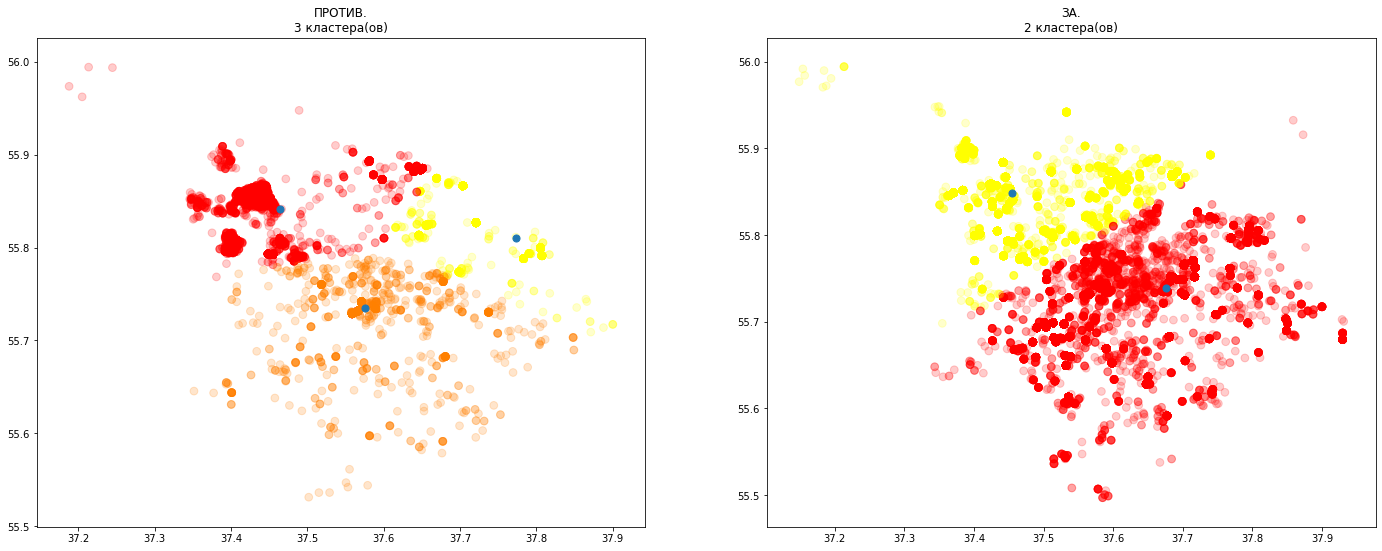

In [12]:
_, axes = plt.subplots(1, 2, figsize=(24, 9))
for ax, X, y_pred, k_opt, centers, title in zip(axes,
                                                [X_vf, X_va],
                                                [y_pred_vf, y_pred_va],
                                                [k_opt_vf, k_opt_va],
                                                [centers_vf, centers_va],
                                                ["ПРОТИВ", "ЗА"]):
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='autumn', s=60, alpha=0.2)
    ax.scatter(centers[:, 0], centers[:, 1], s=50)
    ax.set_title("{}.\n{} кластера(ов)".format(title, k_opt))

plt.show()

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию